# Churn Prediction
Notebook by Tobias Kessel (https://www.linkedin.com/in/tobias-kessel-045806b5/)

__The dataset consists of 8 000 data points stored as rows with 13 features in columns__  
The goal is, to provide an algorithm that can reliably predict churn candidates
***

- Nachname: Last name of customer
- Vorname: First name of customer
- Kundennummer: Customer ID
- Land: Country of origin
- Geschlecht: Sex of the customer (w: female, m: male)
- Alter: Age
- Aktiv: Active Contracts?
- Bonitaet: Credit score of customer
- Dauer: Duration of ensurance contracts
- Konto: Balance
- NrProdukte: Number of insurance products
- HatCrKarte: If the customer has a credit card
- Gesch_Einkommen: Estimated income
- Austritt: TARGET -> If the customer has churned to another insurance
***

# __Step 1:__ 
Importing libraries and CSV

In [466]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, classification_report
from sklearn.svm import SVC

from warnings import simplefilter
simplefilter(action='ignore')

In [524]:
df=pd.read_csv('churn_daten.csv')

# Step 2:
Data Assessment / Exploratory Data Analysis

In [546]:
df.sample(5)

,Nachname,Vorname,KundenNr,Land,Geschlecht,Alter,Aktiv,Bonitaet,Dauer,Konto,NrProdukte,HatCrKarte,Gesch_Einkommen,Austritt
1198,Johnson,Anna,139905585,Frankreich,w,62,1,564,5,114931.35,3,0,18260.98,1
5939,Rios,Ruth,139906594,Deutschland,w,38,0,705,3,123894.43,1,1,21177.10,0
5253,Adams,Gregory,139814231,Deutschland,m,40,0,775,9,126212.64,1,1,70196.57,0
6968,Atwater,George,139824403,England,m,37,1,613,3,171653.17,1,0,5353.12,0
3933,Davis,Katherine,139845331,England,w,36,0,668,3,133686.52,1,1,190958.48,1


In [547]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 7999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Nachname         8000 non-null   object 
 1   Vorname          8000 non-null   object 
 2   KundenNr         8000 non-null   int64  
 3   Land             8000 non-null   object 
 4   Geschlecht       8000 non-null   object 
 5   Alter            8000 non-null   int64  
 6   Aktiv            8000 non-null   int64  
 7   Bonitaet         8000 non-null   int64  
 8   Dauer            8000 non-null   int64  
 9   Konto            8000 non-null   float64
 10  NrProdukte       8000 non-null   int64  
 11  HatCrKarte       8000 non-null   int64  
 12  Gesch_Einkommen  8000 non-null   float64
 13  Austritt         8000 non-null   int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 937.5+ KB


In [549]:
print(len(df['KundenNr'].unique()))
print('No double entries in feature KundenNr')

8000
No double entries in feature KundenNr


In [551]:
print(df.isna().sum())
print('No missing values!')

Nachname           0
Vorname            0
KundenNr           0
Land               0
Geschlecht         0
Alter              0
Aktiv              0
Bonitaet           0
Dauer              0
Konto              0
NrProdukte         0
HatCrKarte         0
Gesch_Einkommen    0
Austritt           0
dtype: int64
No missing values!


In [452]:
print('Ratio of Exited to non-Exited:')
print('{} vs. {}'.format(df['Austritt'].sum(),df.shape[0]-df['Austritt'].sum()))
print('{:2.2%} vs. {:2.2%}'.format(df['Austritt'].value_counts(normalize=True)[1],df['Austritt'].value_counts(normalize=True)[0]))

Ratio of Exited to non-Exited:
934 vs. 7066
11.68% vs. 88.33%


In [453]:
df['Dauer'].value_counts()

2     840
7     839
1     829
5     818
8     808
3     806
4     794
6     780
9     777
10    383
0     326
Name: Dauer, dtype: int64

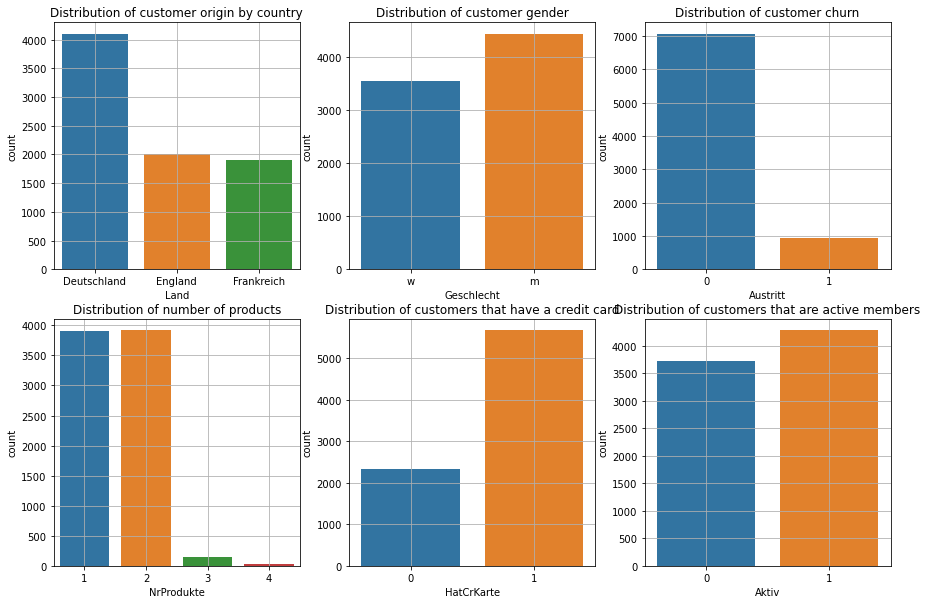

In [493]:
plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
sns.countplot(x='Land',data=df)
plt.title('Distribution of customer origin by country')
plt.grid();

plt.subplot(2,3,2)
sns.countplot(x='Geschlecht',data=df)
plt.title('Distribution of customer gender')
plt.grid();

plt.subplot(2,3,3)
sns.countplot(x='Austritt',data=df)
plt.title('Distribution of customer churn')
plt.grid();

plt.subplot(2,3,4)
sns.countplot(x='NrProdukte',data=df)
plt.title('Distribution of number of products')
plt.grid();

plt.subplot(2,3,5)
sns.countplot(x='HatCrKarte',data=df)
plt.title('Distribution of customers that have a credit card')
plt.grid();

plt.subplot(2,3,6)
sns.countplot(x='Aktiv',data=df)
plt.title('Distribution of customers that are active members')
plt.grid();

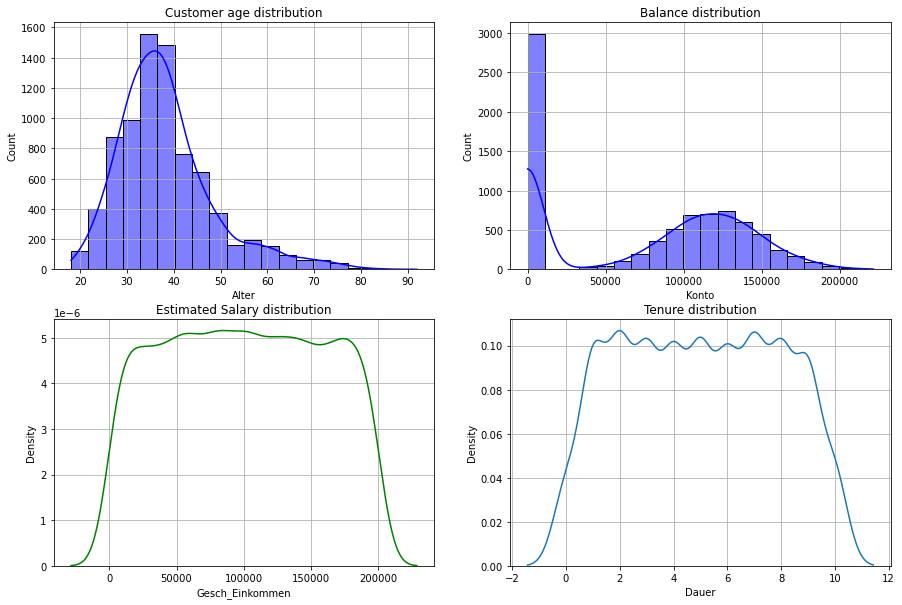

In [455]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))


sns.histplot(ax=axes[0,0],x='Alter',data=df,bins=20,kde=True,color="blue")
axes[0,0].set_title('Customer age distribution')
axes[0,0].grid()

sns.histplot(ax=axes[0,1],x='Konto',data=df,bins=20,kde=True,color="blue")
axes[0,1].set_title('Balance distribution')
axes[0,1].grid()

sns.kdeplot(ax=axes[1,0],x='Gesch_Einkommen',data=df,color="green")
axes[1,0].set_title('Estimated Salary distribution')
axes[1,0].grid()

sns.kdeplot(ax=axes[1,1],x='Dauer',data=df)
axes[1,1].set_title('Tenure distribution')
axes[1,1].grid()

# Step 2
Data Preparation

In [456]:
# Dropping of irrelevant features: 'Vorname', 'Nachname', 'KundenNr' & 'Land'
df.drop(['Vorname','Nachname','KundenNr','Land'],inplace=True,axis=1)

In [457]:
# Changing feature 'NrProdukte' to object as it is categorical
df['NrProdukte']=df['NrProdukte'].astype('object')

# Encoding modalities of feature 'Geschlecht'
df['Geschlecht']=[0 if x == 'Male' else 1 for x in df['Geschlecht']]

In [458]:
y=df['Austritt']
X=df.drop('Austritt',axis=1)

In [459]:
# One-Hot-Encoding of feature 'NrProdukte'
X=X.join(pd.get_dummies(X['NrProdukte'],prefix='NP'))
X.drop('NrProdukte',inplace=True, axis=1)

# Step 3
Setting up Classifier

In [403]:
X

,Bonitaet,Geschlecht,Alter,Dauer,Konto,HatCrKarte,Aktiv,Gesch_Einkommen,NP_1,NP_2,NP_3,NP_4
0,656,1,48,9,0.00,1,1,85240.61,0,1,0,0
1,540,1,28,8,0.00,0,0,197588.32,0,1,0,0
2,640,1,46,3,0.00,1,1,156260.08,1,0,0,0
3,543,1,31,4,138317.94,0,0,61843.73,1,0,0,0
4,661,1,47,0,109493.62,0,0,188324.01,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7995,668,1,32,1,134446.04,0,1,111241.37,1,0,0,0
7996,569,1,35,2,109196.66,1,0,109393.19,0,0,1,0
7997,579,1,31,9,0.00,1,0,112395.98,0,1,0,0
7998,696,1,43,4,0.00,1,1,66406.37,0,1,0,0


In [404]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)

In [405]:
# Standardizing of features 'Bonitaet', 'Alter', 'Konto' & 'Gesch_Einkommen'
columns=['Bonitaet', 'Alter', 'Konto', 'Gesch_Einkommen']
scaler=StandardScaler()
scaler.fit(X_train[columns])
X_train[columns]=scaler.transform(X_train[columns])
X_test[columns]=scaler.transform(X_test[columns])

First quick fit & evaluation of results

In [463]:
clf=SVC()
clf.fit(X_train,y_train)
print('Score: ',clf.score(X_test,y_test))

Score:  0.896


In [407]:
y_pred=clf.predict(X_test)
print(pd.crosstab(y_test, y_pred, rownames=['Real Values'], colnames=['Predicted Values']))

Predicted Values     0   1
Real Values               
0                 1756  10
1                  198  36


In [408]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1766
           1       0.78      0.15      0.26       234

    accuracy                           0.90      2000
   macro avg       0.84      0.57      0.60      2000
weighted avg       0.89      0.90      0.86      2000



Overall peformance is not sufficient
***
The mode 'Austritt = 1' is not well detected by the algorithm, probably due unsufficient training due to under-representation in the dataset  
Therefore oversampling is necessary

In [409]:
smote=SMOTE()
X_os,y_os=smote.fit_resample(X_train,y_train)

In [410]:
y_os.value_counts()

0    5300
1    5300
Name: Austritt, dtype: int64

In [411]:
clf=SVC()
clf.fit(X_os,y_os)

y_pred=clf.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Real Values'], colnames=['Predicted Values']))

print(classification_report(y_test,y_pred))

Predicted Values     0    1
Real Values                
0                 1429  337
1                   76  158
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1766
           1       0.32      0.68      0.43       234

    accuracy                           0.79      2000
   macro avg       0.63      0.74      0.65      2000
weighted avg       0.88      0.79      0.82      2000



The recall of case 1 goes up a lot
***
Trying to further boost the result by defining class weights

In [464]:
# double weight for case 1 (Austritt = 1)
weights={0:1,1:2}
clf=SVC(class_weight=weights)
clf.fit(X_os,y_os)

y_pred=clf.predict(X_test)

print(pd.crosstab(y_test, y_pred, rownames=['Real Values'], colnames=['Predicted Values']))

print(classification_report(y_test,y_pred))

Predicted Values     0    1
Real Values                
0                 1204  562
1                   47  187
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1766
           1       0.25      0.80      0.38       234

    accuracy                           0.70      2000
   macro avg       0.61      0.74      0.59      2000
weighted avg       0.88      0.70      0.75      2000



# Step 4
Results and Conclusion

Class 1 (Exited) could be well detected with a recall of 0.80  
Trade-off: The precision if quite low

The means 752 customers would need to be contacted preemptively but that would include 79% of customers that were thinking about switching to another ensurance.  
By adjusting the weights the recall can be raised, with the tradeoff of a lower precision